In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from omath_mota_rulo import config
from omath_mota_rulo.data import capacidad_hospitalaria
from omath_mota_rulo.features import critical_peaks

In [3]:
config.VERBOSE = False

data = capacidad_hospitalaria.get()
peaks_data = critical_peaks.get()

/Users/lsanchez/omath_mota_rulo/omath_mota_rulo/features/critical_peaks.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data.sort_values('fecha', inplace=True)


In [4]:
data.head()

,datasetid,recordid,record_timestamp,estatus_capacidad_hospitalaria,fecha,coordenadas,institucion,nombre_hospital,estatus_capacidad_uci,geometry.type,geometry.coordinates,estatus_capacidad_uci_
1265,capacidad-hospitalaria,cbc3d414f11bd6a8dff1fdd8667c01cb8f892e34,2020-11-25T18:21:56.210000+00:00,Crítica,2020-05-01,"[19.290295, -99.160861]",SSA,HOSPITAL GENERAL DR. MANUEL GEA GONZÁLEZ,Crítica,Point,"[-99.160861, 19.290295]",3.0
1266,capacidad-hospitalaria,9da33cf9a2d27a5210cc413f32219f4157083eb8,2020-11-25T18:21:56.210000+00:00,Crítica,2020-05-01,"[19.307226, -99.065356]",SEDESA,BELISARIO DOMINGUEZ,Buena,Point,"[-99.065356, 19.307226]",1.0
1267,capacidad-hospitalaria,96f7fc8ba78089ca67ea85ee919cc1a1523c5a87,2020-11-25T18:21:56.210000+00:00,Crítica,2020-05-01,"[19.361675, -99.224432]",SEDESA,ENRIQUE CABRERA,Buena,Point,"[-99.224432, 19.361675]",1.0
1268,capacidad-hospitalaria,9862322d699e259ea1f393cc8c4504ca65887594,2020-11-25T18:21:56.210000+00:00,NaN,2020-05-01,"[19.439732, -99.224235]",SEDESA,CITIBANAMEX,NaN,Point,"[-99.224235, 19.439732]",NaN
1269,capacidad-hospitalaria,cac316dc7a155b1cff63de6dbc536440d10114e5,2020-11-25T18:21:56.210000+00:00,Buena,2020-05-01,"[19.466549, -99.145102]",IMSS,HOSPITAL DE ESPECIALIDADES 01 CMN SIGLO XXI (C...,Crítica,Point,"[-99.145102, 19.466549]",3.0


In [5]:
capacidad = {}
for date, date_data in data.set_index('fecha').groupby(pd.Grouper(freq='D')):
    capacidad[date] = date_data['estatus_capacidad_uci'].value_counts()
    
capacidad = pd.DataFrame(capacidad).T

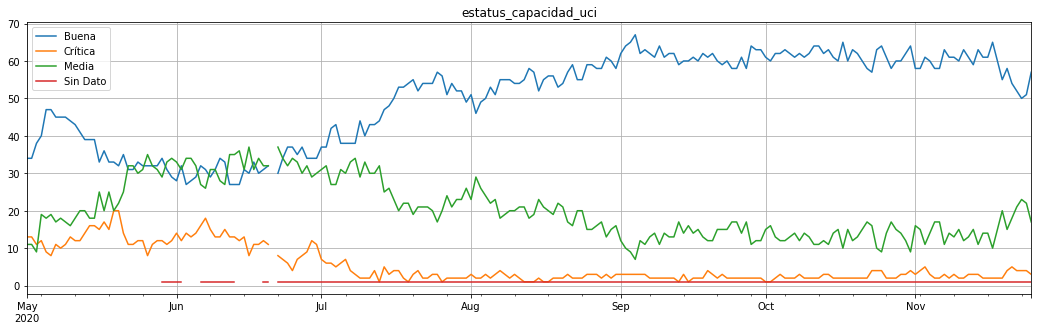

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

capacidad.plot(
    title='estatus_capacidad_uci',
    ax=ax,
    grid=True)

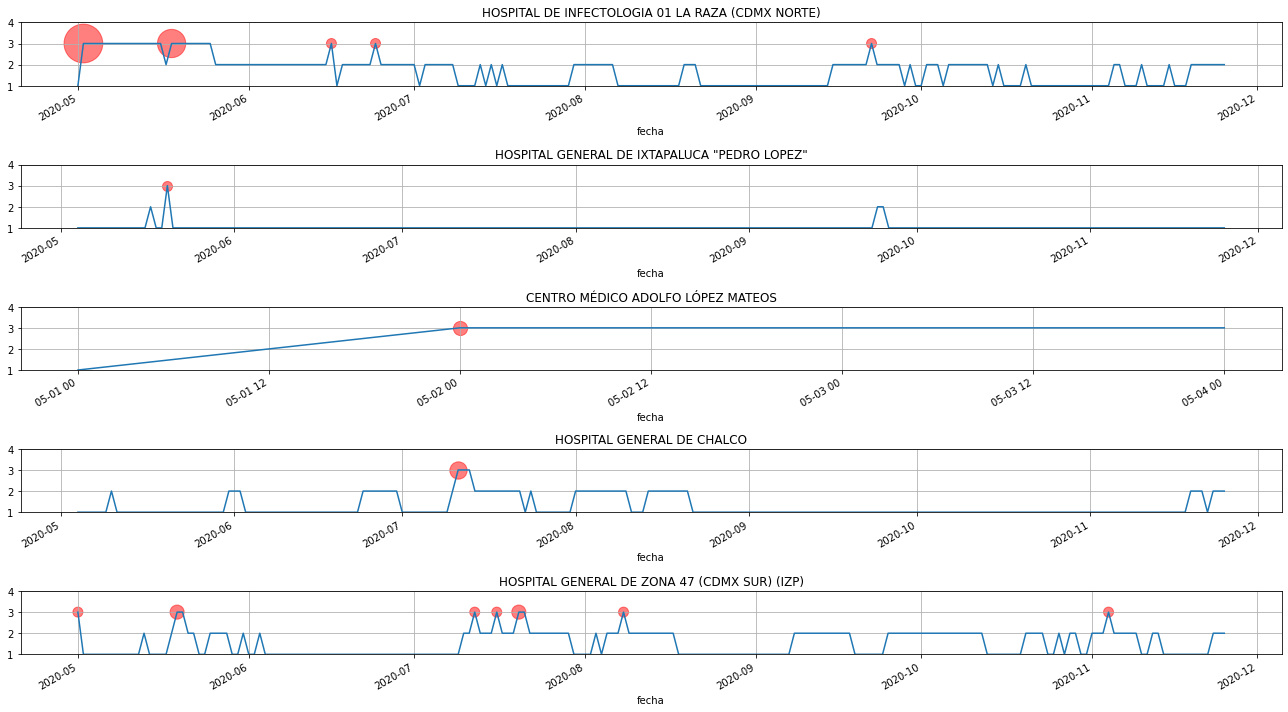

In [25]:
n_samples = 5

sample_hospitals = data[
    data['estatus_capacidad_uci'] == 'Crítica'
][
    'nombre_hospital'
].drop_duplicates().sample(
    n_samples, 
    random_state=3)

# sample_hospitals = ['ALTA ESPECIALIDAD DE ZUMPANGO', 'UNIDAD MÓVIL TEMPORAL COVID']
n_sample_hospitals = len(sample_hospitals)

fig, ax = plt.subplots(
    n_sample_hospitals, 1, 
    figsize=(18, n_sample_hospitals * 2))

for it, hospital in enumerate(sample_hospitals):
    hospital_data = data[data['nombre_hospital'] == hospital]
    hospital_peaks_data = peaks_data[peaks_data['nombre_hospital'] == hospital]
    
    hospital_data.set_index('fecha')['estatus_capacidad_uci_'].plot(
        grid=True, 
        ax=ax[it])
    
    ax[it].set_title(hospital)
    
    ax[it].scatter(
        x=hospital_peaks_data['peak_date'].apply(date2num),
        y=[3] * hospital_peaks_data.shape[0],
        s=hospital_peaks_data['peak_length'] * 100,
        color='r',
        alpha=.5)
    
    ax[it].set_ylim(1, 4)

fig.set_tight_layout('tight')

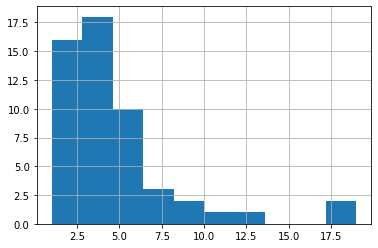

In [31]:
fig, ax = plt.subplots(
    n_sample_hospitals, 1, 
    figsize=(18, n_sample_hospitals * 2))

peaks_data['nombre_hospital'].value_counts().hist()